# [`ml4gw`](https://github.com/ML4GW/ml4gw) Tutorial

This tutorial has two parts:
1. An overview of many of the features of `ml4gw`, with demonstrations
2. An example of training a model using these features

**Requirements:** This notebook requires a number of packages besides `ml4gw` to run completely.
Install with:

```bash
pip install "ml4gw>=0.7.6" "gwpy>=3.0" "h5py>=3.12" "torchmetrics>=1.6" "lightning>=2.4.0" "rich>=10.2.2,<14.0"


## Overview

We'll go through this as though our goal is to build a binary black hole detection model, 
with some excursions to look at other features. Much of this is similar to how the [Aframe](https://www.github.com/ML4GW/aframe) algorithm works.
The development of `ml4gw` was guided by what was needed for Aframe,
which makes BBH detection a good test case.

Goals of this tutorial:
- Introduce and demonstrate how to interact with many of the features of `ml4gw`
- Explain why these tools are useful for doing machine learning in gravitational wave physics
- Present areas where it may be possible to contribute to `ml4gw`

In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Computer Modern",
        "font.size": 16,
    }
)

# Most of this notebook can be run on CPU in a reasonable amount of time.
# The example training at the end cannot be.
device = "cuda" if torch.cuda.is_available() else "cpu"

## Waveform Generation

We'll start by generating some BBH waveforms. Currently, `ml4gw` has implemented the following [CBC waveforms](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/waveforms/cbc): TaylorF2, IMRPhenomD, and IMRPhenomPv2. We'll use IMRPhenomD for our example. These are all frequency-domain waveforms, and so return a frequency-series of gravitational-wave strain. We provide the [`TimeDomainCBCWaveformGenerator`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/waveforms/generator.py) class for producing time-domain signals; however, we'll start with frequency-domain.

Additionally, sine-gaussian and ringdown (damped cosinusoidal) waveforms are [available](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/waveforms/adhoc).

These modules allow simultaneous generation of batches of waveforms from a set of parameters.

In [2]:
# Desired duration of time-domain waveform
waveform_duration = 8
# Sample rate of all the data we'll be using today
sample_rate = 2048

# Define minimum, maximum, and reference frequencies
f_min = 20
f_max = 1024
f_ref = 20

nyquist = sample_rate / 2
num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1

# Create an array of frequency values at which to generate our waveform
# At the moment, only frequency-domain approximants have been implemented
frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
freq_mask = (frequencies >= f_min) * (frequencies < f_max).to(device)

### Parameter sampling

To generate waveforms, we need sets of parameters. For creating a training dataset, we'd like to randomly sample these parameters from some probability distributions.

PyTorch has its own [probability distributions](https://pytorch.org/docs/stable/distributions.html), but there are some distributions that they haven't yet implemented (at least at time of writing), so we implemented them [ourselves](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/distributions.py).

In [3]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction
from torch.distributions import Uniform

# On CPU, keep the number of waveforms around 100. On GPU, you can go higher,
# subject to memory constraints.
num_waveforms = 500

# Create a dictionary of parameter distributions
# This is not intended to be an astrophysically
# meaningful distribution
param_dict = {
    "chirp_mass": PowerLaw(10, 100, -2.35),
    "mass_ratio": Uniform(0.125, 0.999),
    "chi1": Uniform(-0.999, 0.999),
    "chi2": Uniform(-0.999, 0.999),
    "distance": PowerLaw(100, 1000, 2),
    "phic": DeltaFunction(0),
    "inclination": Sine(),
}

# And then sample from each of those distributions
params = {
    k: v.sample((num_waveforms,)).to(device) for k, v in param_dict.items()
}

### Generation in the frequency domain

In [4]:
from ml4gw.waveforms import IMRPhenomD

approximant = IMRPhenomD().to(device)

# Calling the approximant with the frequency array, reference frequency, and waveform parameters
# returns the cross and plus polarizations
hc_f, hp_f = approximant(f=frequencies[freq_mask], f_ref=f_ref, **params)
print(hc_f.shape, hp_f.shape)

torch.Size([500, 8032]) torch.Size([500, 8032])


We now have the plus and cross polarizations 500 BBH waveforms in the frequency domain. We can plot one of them, just to take a look:

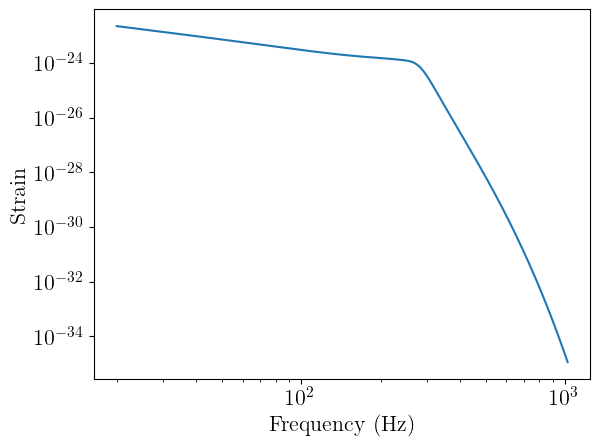

In [5]:
# Note that I have to move data to CPU to plot
# In an actual training setup, you wouldn't be moving data between devices so much
plt.plot(frequencies[freq_mask].cpu(), torch.abs(hp_f[0]).cpu())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.show()

### Time-domain waveforms

We'll now generate waveforms in the time domain using the `TimeDomainCBCWaveformGenerator`. This `Module` uses the `approximant` to generate a waveform `duration` seconds long with the given `sample_rate`. The coalescence point of the signal is placed `right_pad` seconds from the right edge of the window. For conditioning the frequency-domain waveforms, the parameter dictionary is required to contain the `mass_1`, `mass_2`, `s1z`, and `s2z` keys. We'll use a conversion function from [`ml4gw.waveforms.conversion`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/waveforms/conversion.py) to add these keys.

Because we're using IMRPhenomD and have aligned spins `s1z = chi1` and `s2z = chi2`. If we had non-aligned spins, we could use the `bilby_spins_to_lalsim` conversion function to compute the cartesian spin components.

In [6]:
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components

waveform_generator = TimeDomainCBCWaveformGenerator(
    approximant=approximant,
    sample_rate=sample_rate,
    f_min=f_min,
    duration=waveform_duration,
    right_pad=0.5,
    f_ref=f_ref,
).to(device)

params["mass_1"], params["mass_2"] = chirp_mass_and_mass_ratio_to_components(
    params["chirp_mass"], params["mass_ratio"]
)

params["s1z"], params["s2z"] = params["chi1"], params["chi2"]

hc, hp = waveform_generator(**params)
print(hc.shape, hp.shape)

torch.Size([500, 16384]) torch.Size([500, 16384])


We now have 500 BBH waveforms, 8 seconds long and sampled at 2048 Hz. We can plot one of these as well:

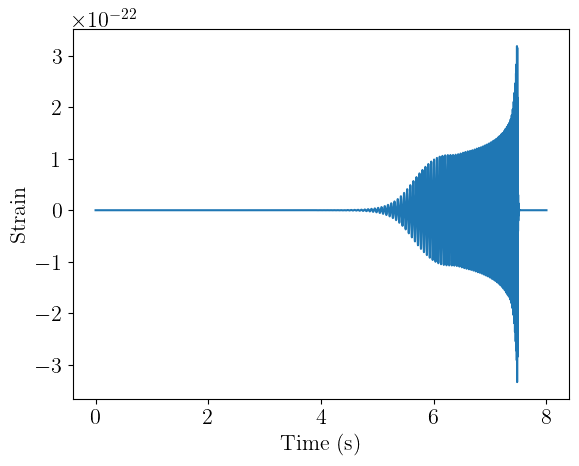

In [7]:
times = torch.arange(0, waveform_duration, 1 / sample_rate)
plt.plot(times, hp[0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

### Waveform projection

We can now project these waveforms and get the observed strain. At present, the projection is the most basic, assuming a fixed orientation between the detector and the source over the duration of the signal. The source code for these functions can be found [here](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/gw.py).

Future feature:
- Account for the Earth's rotation and orbit

In [8]:
from ml4gw.gw import get_ifo_geometry, compute_observed_strain

# Define probability distributions for sky location and polarization angle
dec = Cosine()
psi = Uniform(0, torch.pi)
phi = Uniform(-torch.pi, torch.pi)

# The interferometer geometry for V1 and K1 are also in ml4gw
ifos = ["H1", "L1"]
tensors, vertices = get_ifo_geometry(*ifos)

# Pass the detector geometry, along with the polarizations and sky parameters,
# to get the observed strain
waveforms = compute_observed_strain(
    dec=dec.sample((num_waveforms,)).to(device),
    psi=psi.sample((num_waveforms,)).to(device),
    phi=phi.sample((num_waveforms,)).to(device),
    detector_tensors=tensors.to(device),
    detector_vertices=vertices.to(device),
    sample_rate=sample_rate,
    cross=hc,
    plus=hp,
)
print(waveforms.shape)

torch.Size([500, 2, 16384])


We now have a batch of multi-channel time-series data. The first dimension is the batch dimension, and corresponds to the number of waveforms that were generated. The second dimension is the channel dimension, and corresponds to the interferometers that we chose to use in the order they were specified. The third dimension is the time dimension. 

We can plot this as well, though there won't be much difference from before.

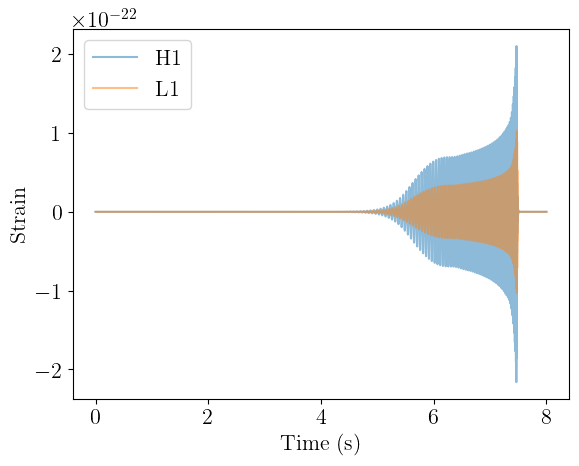

In [9]:
plt.plot(times, waveforms[0, 0].cpu(), label="H1", alpha=0.5)
plt.plot(times, waveforms[0, 1].cpu(), label="L1", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

### PSD Estimation

Now that we have our waveforms generated, one thing we might want to do is calculate their SNRs with respect to some background data. To do that, we'll need the power spectral density of the background. The [`SpectralDensity`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/transforms/spectral.py) module can take a batch of multi-channel timeseries data and compute the PSD along the time dimension. We'll begin by downloading some background data from the Gravitational Wave Open Science Center (GWOSC). This data comes from the Hanford and Livingston and was taken during O3.

One important piece to note is that, due to the scale of the strain, the background data is cast to `double` precision before being given to the module to avoid certain values being zeroed out.

Future feature:
- Automatically cast input data to `double` unless the user specifies otherwise

In [10]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path

# Point this to whatever directory you want to house
# all of the data products this notebook creates
data_dir = Path("./data")

# And this to the directory where you want to download the data
background_dir = data_dir / "background_data"
background_dir.mkdir(parents=True, exist_ok=True)

# These are the GPS time of the start and end of the segments.
# There's no particular reason for these times, other than that they
# contain analysis-ready data
segments = [
    (1240579783, 1240587612), 
    (1240594562, 1240606748), 
    (1240624412, 1240644412),
    (1240644412, 1240654372),
    (1240658942, 1240668052),
]

for (start, end) in segments:
    # Download the data from GWOSC. This will take a few minutes.
    duration = end - start
    fname = background_dir / f"background-{start}-{duration}.hdf5"
    if fname.exists():
        continue

    ts_dict = TimeSeriesDict()
    for ifo in ifos:
        ts_dict[ifo] = TimeSeries.fetch_open_data(ifo, start, end, cache=True)
    ts_dict = ts_dict.resample(sample_rate)
    ts_dict.write(fname, format="hdf5")

/home/william.benoit/ML4GW/ml4gw/.venv/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [11]:
from ml4gw.transforms import SpectralDensity
import h5py

fftlength = 2
spectral_density = SpectralDensity(
    sample_rate=sample_rate,
    fftlength=fftlength,
    overlap=None,
    average="median",
).to(device)

# This is H1 and L1 data from O3 that I downloaded earlier
# We have tools for dataloading that I'll get to later
background_file = background_dir / "background-1240579783-7829.hdf5"
with h5py.File(background_file, "r") as f:
    background = [torch.Tensor(f[ifo][:]) for ifo in ifos]
    background = torch.stack(background).to(device)

# Note cast to double
psd = spectral_density(background.double())
print(psd.shape)

torch.Size([2, 2049])


We can plot the PSDs and see that they look as expected:

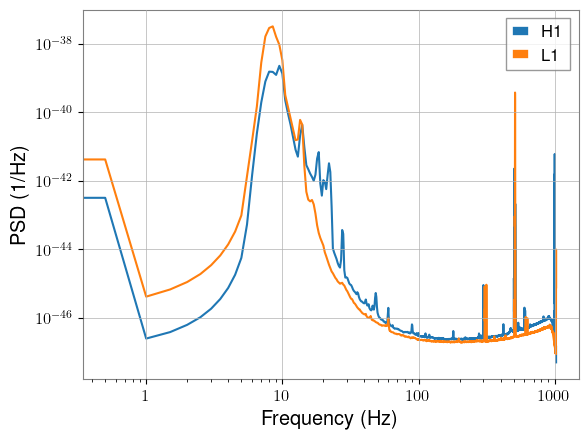

In [12]:
freqs = torch.linspace(0, nyquist, psd.shape[-1])
plt.plot(freqs, psd.cpu()[0], label="H1")
plt.plot(freqs, psd.cpu()[1], label="L1")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/Hz)")
plt.legend()
plt.show()

### SNR Calculation

With the PSD from H1 and L1, we can calculate the SNRs of the waveforms we generated.

Note: the shape of the PSDs is determined by the sampling rate and the FFT length used in the calculation, and so may not match up with the shape of the FFT'ed waveforms. We can interpolate the PSDs so that the dimensions match.

Future feature:
- Do this interpolation automatically somewhere unless the user specifies otherwise

In [13]:
from ml4gw.gw import compute_ifo_snr, compute_network_snr

# Note need to interpolate
if psd.shape[-1] != num_freqs:
    # Adding dummy dimensions for consistency
    while psd.ndim < 3:
        psd = psd[None]
    psd = torch.nn.functional.interpolate(
        psd, size=(num_freqs,), mode="linear"
    )

# We can compute both the individual and network SNRs
# The SNR calculation starts at the minimum frequency we
# specified earlier and goes to the maximum
# TODO: There's probably no reason to have multiple functions
h1_snr = compute_ifo_snr(
    responses=waveforms[:, 0],
    psd=psd[:, 0],
    sample_rate=sample_rate,
    highpass=f_min,
)
l1_snr = compute_ifo_snr(
    responses=waveforms[:, 1],
    psd=psd[:, 1],
    sample_rate=sample_rate,
    highpass=f_min,
)
network_snr = compute_network_snr(
    responses=waveforms, psd=psd, sample_rate=sample_rate, highpass=f_min
)

Let's plot histograms of each of these SNR arrays:

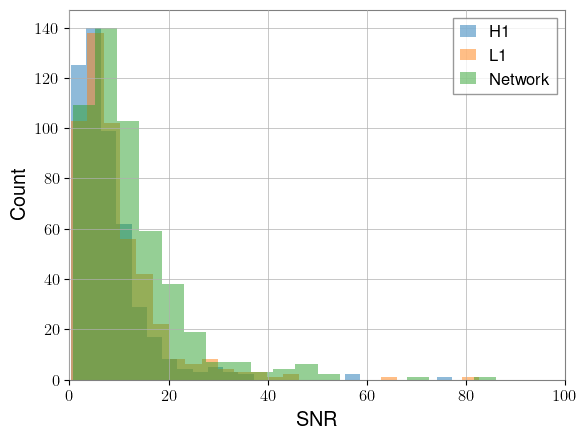

In [14]:
plt.hist(h1_snr.cpu(), bins=25, alpha=0.5, label="H1")
plt.hist(l1_snr.cpu(), bins=25, alpha=0.5, label="L1")
plt.hist(network_snr.cpu(), bins=25, alpha=0.5, label="Network")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.legend()
plt.show()

This looks more or less like expected. But we've got a lot of low SNR signals, which a search will have trouble detecting. We can rescale our waveforms so that the SNR distribution is more favorable. This could be useful for something like curriculum learning: your network could begin with higher SNR events, and slowly be shown lower SNR events as training continues.

We'll create an array of target SNRs based on a power law distribution that very roughly matches the above, but with a minimum SNR of 12 and maximum of 100.

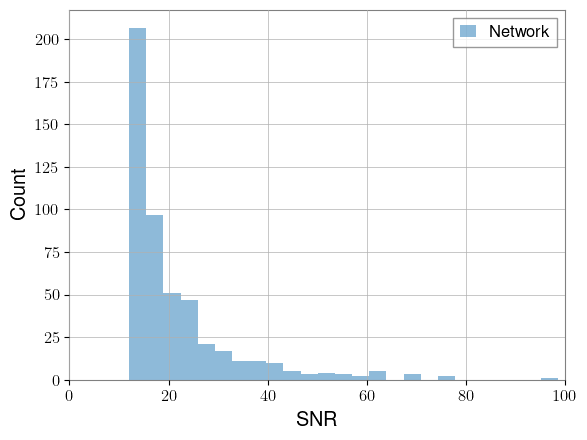

In [15]:
from ml4gw.gw import reweight_snrs

target_snrs = PowerLaw(12, 100, -3).sample((num_waveforms,)).to(device)
# Each waveform will be scaled by the ratio of its target SNR to its current SNR
waveforms = reweight_snrs(
    responses=waveforms,
    target_snrs=target_snrs,
    psd=psd,
    sample_rate=sample_rate,
    highpass=f_min,
)

network_snr = compute_network_snr(
    responses=waveforms, psd=psd, sample_rate=sample_rate, highpass=f_min
)

plt.hist(network_snr.cpu(), bins=25, alpha=0.5, label="Network")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.legend()
plt.show()

We now have a set of waveforms that are much easier to detect.

## Dataloading

When training a model, it's beneficial to provide as much variety in data as you can. We benefit from having multiple independent detectors, which allows for combinatorially more background samples than a single detector would, as the samples don't have to be coincident.

The [`Hdf5TimeSeriesDataset`](https://github.com/ML4GW/ml4gw/blob/6c68f4bade88362d5d6d27e912410a84765d09a0/ml4gw/dataloading/hdf5_dataset.py#L15) allows for randomly sampling windows of data from hdf5 files, provided they all have the same structure. Here, we have a set of background files, each containing H1 and L1 strain data. We could chop this data up into samples prior to training, but we'd be limited by the number of samples we could create and fit on disk. Instead, during training, we grab the data we need for each batch by randomly sampling from all of these files, giving us effectively unlimited background data to train on.

Future feature:
- Allow sampling from multiple datasets within the same file

In [16]:
!ls data/background_data/

background-1240579783-7829.hdf5   background-1240644412-9960.hdf5
background-1240594562-12186.hdf5  background-1240658942-9110.hdf5
background-1240624412-20000.hdf5


In [17]:
from ml4gw.dataloading import Hdf5TimeSeriesDataset

# Defining some parameters for future use, and to
# determine the size of the windows to sample.
# We're going to be whitening the last part of each
# window with a PSD calculated from the first part,
# so we need to grab enough data to do that

# Length of data used to estimate PSD
psd_length = 16
psd_size = int(psd_length * sample_rate)

# Length of filter. A segment of length fduration / 2
# will be cropped from either side after whitening
fduration = 2

# Length of window of data we'll feed to our network
kernel_length = 1.5
kernel_size = int(1.5 * sample_rate)

# Total length of data to sample
window_length = psd_length + fduration + kernel_length

fnames = list(background_dir.iterdir())
dataloader = Hdf5TimeSeriesDataset(
    fnames=fnames,
    channels=ifos,
    kernel_size=int(window_length * sample_rate),
    batch_size=2
    * num_waveforms,  # Grab twice as many background samples as we have waveforms
    batches_per_epoch=1,  # Just doing 1 here for demonstration purposes
    coincident=False,
)

background_samples = [x for x in dataloader][0].to(device)
print(background_samples.shape)

torch.Size([1000, 2, 39936])


## Whitening

It's crucial to normalize your data before putting it through a neural network, and whitening provides a physically meaningful way of doing that. The [`Whiten`](https://github.com/ML4GW/ml4gw/blob/6c68f4bade88362d5d6d27e912410a84765d09a0/ml4gw/transforms/whitening.py#L15) module will whiten and optionally highpass batches of multi-channel data with a provided set of PSDs. If the tensor of PSDs is 2D, each batch element of data will be whitened using the same PSDs. If 3D, each batch element will be whitened by the PSDs contained along the 0th dimension. In other words, you can provide a single PSD for each channel to whiten all elements in that channel, or you can provide a PSD for each element. We're doing the latter here.

Note that the whitening process automatically removes `fduration / 2` seconds from either side of the input data.

Future feature:
- Add an option to not crop

In [18]:
from ml4gw.transforms import Whiten

whiten = Whiten(
    fduration=fduration, sample_rate=sample_rate, highpass=f_min
).to(device)

# Create PSDs using the first psd_length seconds of each sample
# with the SpectralDensity module we defined earlier
psd = spectral_density(background_samples[..., :psd_size].double())
print(f"PSD shape: {psd.shape}")

# Take everything after the first psd_length as our input kernel
kernel = background_samples[..., psd_size:]
# And whiten using our PSDs
whitened_kernel = whiten(kernel, psd)
print(f"Kernel shape: {kernel.shape}")
print(f"Whitened kernel shape: {whitened_kernel.shape}")

PSD shape: torch.Size([1000, 2, 2049])
Kernel shape: torch.Size([1000, 2, 7168])
Whitened kernel shape: torch.Size([1000, 2, 3072])


Plotting the first segment of strain, we can see that the data looks as expected. For visual clarity, the plots show only H1 data. Again, note the difference in length before and after whitening.

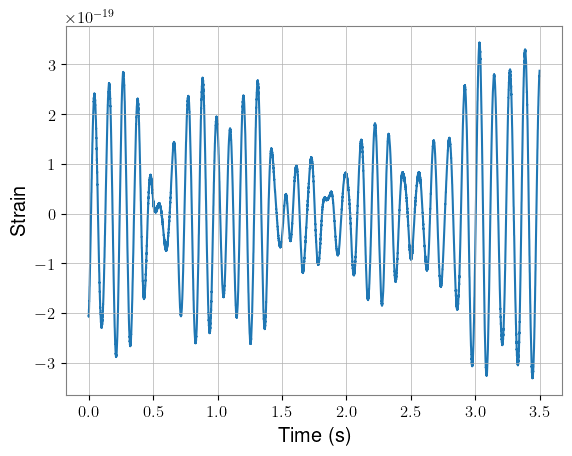

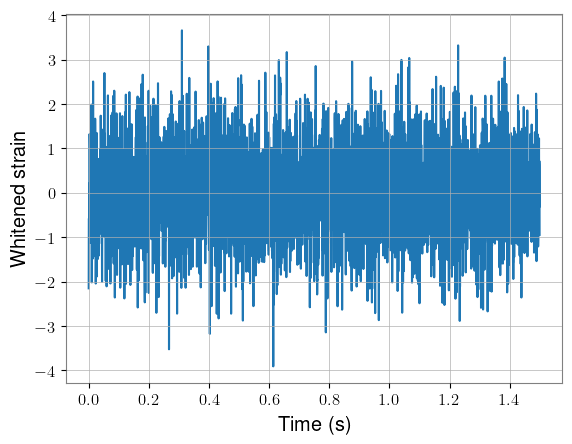

In [19]:
times = torch.arange(0, kernel_length + fduration, 1 / sample_rate)
plt.plot(times, kernel[0, 0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

times = torch.arange(0, kernel_length, 1 / sample_rate)
plt.plot(times, whitened_kernel[0, 0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.show()

Next, we can add our waveforms into half of these background samples, taking care not to add them into data that will be removed during whitening. We'll use only the final `kernel_length` seconds of each waveform.

In [20]:
pad = int(fduration / 2 * sample_rate)
injected = kernel.detach().clone()
# Inject waveforms into every other background sample
injected[::2, :, pad:-pad] += waveforms[..., -kernel_size:]
# And whiten with the same PSDs as before
whitened_injected = whiten(injected, psd)

We can plot one of these as well, using the loudest signal for visibility.

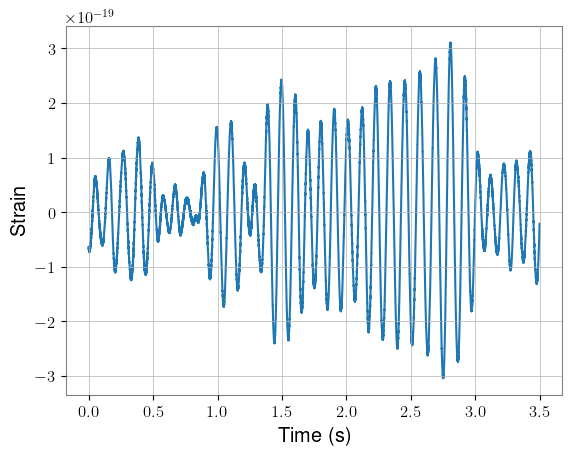

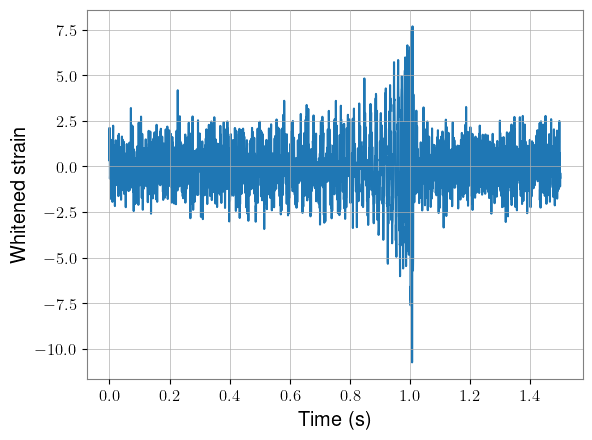

In [21]:
# Factor of 2 because we injected every other sample
idx = 2 * torch.argmax(network_snr)

times = torch.arange(0, kernel_length + fduration, 1 / sample_rate)
plt.plot(times, injected[idx, 0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.show()

times = torch.arange(0, kernel_length, 1 / sample_rate)
plt.plot(times, whitened_injected[idx, 0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.show()

We'll use this dataset we just created as a validation dataset during the training example, so I'll create a tensor of labels and save everything to file.

In [22]:
y = torch.zeros(len(injected))
y[::2] = 1
with h5py.File(data_dir / "validation_dataset.hdf5", "w") as f:
    f.create_dataset("X", data=whitened_injected.cpu())
    f.create_dataset("y", data=y)

## Transforms

If we wanted to, we could stop with our data as-is and train a time-domain model (which is what we'll do in the example). But we could also transform our data into the time-frequency domain to create spectrograms, and treat this as an image classification problem. `ml4gw` has two methods for doing that: the [`MultiResolutionSpectrogram`](https://github.com/ML4GW/ml4gw/blob/6c68f4bade88362d5d6d27e912410a84765d09a0/ml4gw/transforms/spectrogram.py#L13) and the [`Q-transform`](https://github.com/ML4GW/ml4gw/blob/6c68f4bade88362d5d6d27e912410a84765d09a0/ml4gw/transforms/qtransform.py#L154).

The multi-resolution spectrogram module creates a single spectrogram by combining multiple spectrograms that were calculated using different numbers of FFTs. This is similar to what PySTAMPAS does as part of their pipeline. The Q-transform is a translation of GWpy's implementation, with some torch-specific speed-ups.

The spectrogram module uses torchaudio's [`Spectrogram`](https://pytorch.org/audio/main/generated/torchaudio.transforms.Spectrogram.html) object, and can accept any of the same keyword arguments, given in a list. 

In [23]:
from ml4gw.transforms import (
    MultiResolutionSpectrogram,
    QScan,
    SingleQTransform,
)

mrs = MultiResolutionSpectrogram(
    kernel_length=kernel_length,
    sample_rate=sample_rate,
    n_fft=[
        64,
        128,
        256,
    ],  # Specififying just one value will create a single-resolution spectrogram
).to(device)

# The Q-transform can be accessed either through the QScan,
# which will look over a range of q values, or through the
# SingleQTransform, which uses a given q value
qscan = QScan(
    duration=kernel_length,
    sample_rate=sample_rate,
    spectrogram_shape=[512, 512],
    qrange=[4, 128],
).to(device)
sqt = SingleQTransform(
    duration=kernel_length,
    sample_rate=sample_rate,
    spectrogram_shape=[512, 512],
    q=12,
).to(device)

We'll pass our whitened and injected data to each of these transforms, which will process the entire batch at once, and plot the first sample.

Note: the axes on each plot correspond to a bin index, not the actual time and frequency

Note: the multi-resolution spectrogram has linearly-spaced frequency bins, while the Q-transform has log-spaced bins

Neither of these aspects are really a problem for training a model (all that really matters is that you treat all your data the same way), but it's annoying when it comes to making plots.

Future features:
- Store the time and frequency values corresponding to each bin as attributes of the object
- Allow either frequency bin spacing

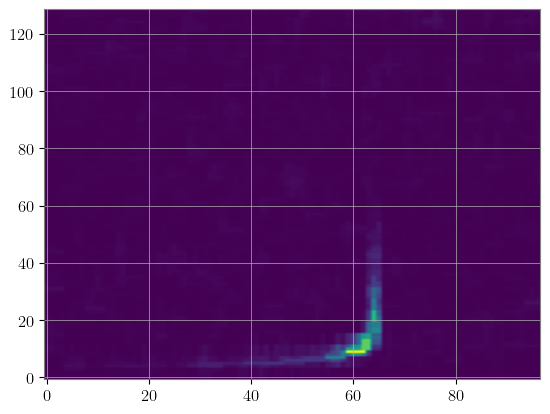

In [24]:
specgram = mrs(whitened_injected)
plt.imshow(specgram[idx, 0].cpu(), aspect="auto", origin="lower")
plt.show()

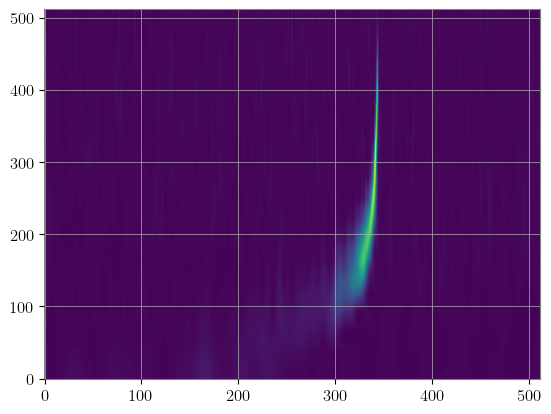

In [25]:
specgram = qscan(whitened_injected)
plt.imshow(specgram[idx, 0].cpu(), aspect="auto", origin="lower")
plt.show()

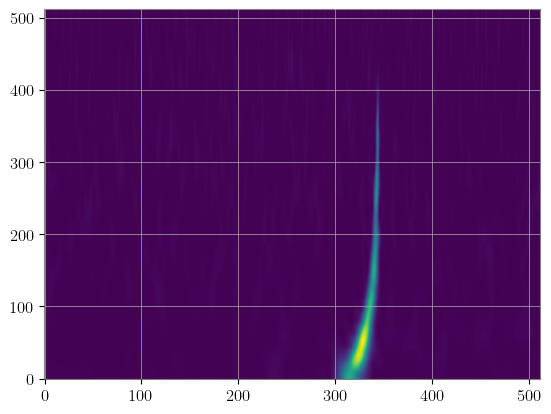

In [26]:
specgram = sqt(whitened_injected)
plt.imshow(specgram[idx, 0].cpu(), aspect="auto", origin="lower")
plt.show()

The big benefit here is _speed_. We computed 2,000 Q-transforms in a fraction of a second. The downside is that we needed to use the same q value for each of them, but there are applications where that may not be a problem. For instance, BBH signals are typically better represented with lower q values. 

There are other [transforms](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/transforms) that I don't have time to go into:
- Channel-wise scaler
- Spline interpolation (though note the caveats)
- Fixed whitener, which is fit to a set PSD
- Pearson correlation calculator

Future features:
- Fix edge effects of spline interpolation
- Multi-rate resampling

## Architectures

We've implemented a couple basic [neural network architectures](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/nn) for out-of-the-box convenience. Today, we'll be using a 1D ResNet, which is mostly copied from PyTorch's implementation, but with a few key differences:
- Arbitrary kernel sizes
- `GroupNorm` as the default normalization layer, as training statistics in general won't match testing statistics
- Custom `GroupNorm` implementation which is faster than the standard PyTorch version at inference time

In [27]:
from ml4gw.nn.resnet import ResNet1D

architecture = ResNet1D(
    in_channels=2,  # H1 and L1 as input channels
    layers=[2, 2],  # Keep things small and do a ResNet10
    classes=1,  # Single scalar-valued output
    kernel_size=3,  # Size of convolutional kernels, not to be confused with data size
).to(device)

# And we can, e.g., pass the first element of our validation set
with torch.no_grad():
    print(architecture(whitened_injected[0][None]))

tensor([[-0.2554]], device='cuda:0')


## Example training setup

We'll now go through an example of putting many of these pieces together into a single model, implemented using th [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) framework.

Begin by clearing the GPU:

In [28]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [29]:
from ml4gw import augmentations, distributions, gw, transforms, waveforms
from ml4gw.dataloading import ChunkedTimeSeriesDataset, Hdf5TimeSeriesDataset
from ml4gw.utils.slicing import sample_kernels
import torch
from lightning import pytorch as pl
import torchmetrics
from torchmetrics.classification import BinaryAUROC

from typing import Callable, Dict, List


class Ml4gwDetectionModel(pl.LightningModule):
    """
    Model with methods for generating waveforms and
    performing our preprocessing augmentations in
    real-time on the GPU. Also loads training background
    in chunks from disk, then samples batches from chunks.
    """

    def __init__(
        self,
        architecture: torch.nn.Module,
        metric: torchmetrics.Metric,
        ifos: List[str] = ["H1", "L1"],
        kernel_length: float = 1.5,
        # PSD/whitening args
        fduration: float = 2,
        psd_length: float = 16,
        sample_rate: float = 2048,
        fftlength: float = 2,
        highpass: float = 32,
        # Dataloading args
        chunk_length: float = 128,  # we'll talk about chunks in a second
        reads_per_chunk: int = 40,
        learning_rate: float = 0.005,
        batch_size: int = 256,
        # Waveform generation args
        waveform_prob: float = 0.5,
        approximant: Callable = waveforms.cbc.IMRPhenomD,
        param_dict: Dict[str, torch.distributions.Distribution] = param_dict,
        waveform_duration: float = 8,
        f_min: float = 20,
        f_max: float = None,
        f_ref: float = 20,
        # Augmentation args
        inversion_prob: float = 0.5,
        reversal_prob: float = 0.5,
        min_snr: float = 12,
        max_snr: float = 100,
    ) -> None:
        super().__init__()
        self.save_hyperparameters(
            ignore=["architecture", "metric", "approximant"]
        )
        self.nn = architecture
        self.metric = metric

        self.inverter = augmentations.SignalInverter(prob=inversion_prob)
        self.reverser = augmentations.SignalReverser(prob=reversal_prob)

        # real-time transformations defined with torch Modules
        self.spectral_density = transforms.SpectralDensity(
            sample_rate, fftlength, average="median", fast=False
        )
        self.whitener = transforms.Whiten(
            fduration, sample_rate, highpass=highpass
        )

        # get some geometry information about
        # the interferometers we're going to project to
        detector_tensors, vertices = gw.get_ifo_geometry(*ifos)
        self.register_buffer("detector_tensors", detector_tensors)
        self.register_buffer("detector_vertices", vertices)

        # define some sky parameter distributions
        self.param_dict = param_dict
        self.dec = distributions.Cosine()
        self.psi = torch.distributions.Uniform(0, torch.pi)
        self.phi = torch.distributions.Uniform(
            -torch.pi, torch.pi
        )  # relative RAs of detector and source
        self.waveform_generator = TimeDomainCBCWaveformGenerator(
            approximant=approximant(),
            sample_rate=sample_rate,
            duration=waveform_duration,
            f_min=f_min,
            f_ref=f_ref,
            right_pad=0.5,
        ).to(self.device)

        # rather than sample distances, we'll sample target SNRs.
        # This way we can ensure we train our network on
        # signals that are more detectable. We'll use a distribution
        # that looks roughly like the natural sampled SNR distribution
        self.snr = distributions.PowerLaw(min_snr, max_snr, -3)

        # up front let's define some properties in units of samples
        # Note the different usage of window_size from earlier
        self.kernel_size = int(kernel_length * sample_rate)
        self.window_size = self.kernel_size + int(fduration * sample_rate)
        self.psd_size = int(psd_length * sample_rate)

    def forward(self, X):
        return self.nn(X)

    def training_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch):
        X, y = batch
        y_hat = self(X)
        self.metric.update(y_hat, y)
        self.log("valid_auroc", self.metric, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        parameters = self.nn.parameters()
        optimizer = torch.optim.AdamW(parameters, self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.hparams.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)

    def configure_callbacks(self):
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_auroc", mode="max")
        return [chkpt]

    def generate_waveforms(self, batch_size: int) -> tuple[torch.Tensor, ...]:
        rvs = torch.rand(size=(batch_size,))
        mask = rvs < self.hparams.waveform_prob
        num_injections = mask.sum().item()

        params = {
            k: v.sample((num_injections,)).to(device)
            for k, v in self.param_dict.items()
        }

        params["s1z"], params["s2z"] = (
            params["chi1"], params["chi2"]
        )
        params["mass_1"], params["mass_2"] = waveforms.conversion.chirp_mass_and_mass_ratio_to_components(
            params["chirp_mass"], params["mass_ratio"]
        )

        hc, hp = self.waveform_generator(**params)
        return hc, hp, mask

    def project_waveforms(
        self, hc: torch.Tensor, hp: torch.Tensor
    ) -> torch.Tensor:
        # sample sky parameters
        N = len(hc)
        dec = self.dec.sample((N,)).to(hc)
        psi = self.psi.sample((N,)).to(hc)
        phi = self.phi.sample((N,)).to(hc)

        # project to interferometer response
        return gw.compute_observed_strain(
            dec=dec,
            psi=psi,
            phi=phi,
            detector_tensors=self.detector_tensors,
            detector_vertices=self.detector_vertices,
            sample_rate=self.hparams.sample_rate,
            cross=hc,
            plus=hp,
        )

    def rescale_snrs(
        self, responses: torch.Tensor, psd: torch.Tensor
    ) -> torch.Tensor:
        # make sure everything has the same number of frequency bins
        num_freqs = int(responses.size(-1) // 2) + 1
        if psd.size(-1) != num_freqs:
            psd = torch.nn.functional.interpolate(
                psd, size=(num_freqs,), mode="linear"
            )
        N = len(responses)
        target_snrs = self.snr.sample((N,)).to(responses.device)
        return gw.reweight_snrs(
            responses=responses.double(),
            target_snrs=target_snrs,
            psd=psd,
            sample_rate=self.hparams.sample_rate,
            highpass=self.hparams.highpass,
        )

    def sample_waveforms(self, responses: torch.Tensor) -> torch.Tensor:
        # slice off random views of each waveform to inject in arbitrary positions
        responses = responses[:, :, -self.window_size :]

        # pad so that at least half the kernel always contains signals
        pad = [0, int(self.window_size // 2)]
        responses = torch.nn.functional.pad(responses, pad)
        return sample_kernels(responses, self.window_size, coincident=True)

    @torch.no_grad()
    def augment(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(
            X, [self.psd_size, self.window_size], dim=-1
        )
        psd = self.spectral_density(background.double())

        # Generate at most batch_size signals from our parameter distributions
        # Keep a mask that indicates which rows to inject in
        batch_size = X.size(0)
        hc, hp, mask = self.generate_waveforms(batch_size)
        hc, hp, mask = hc, hp, mask

        # Augment with inversion and reversal
        X = self.inverter(X)
        X = self.reverser(X)

        # sample sky parameters and project to responses, then
        # rescale the response according to a randomly sampled SNR
        responses = self.project_waveforms(hc, hp)
        responses = self.rescale_snrs(responses, psd[mask])

        # randomly slice out a window of the waveform, add it
        # to our background, then whiten everything
        responses = self.sample_waveforms(responses)
        X[mask] += responses.float()
        X = self.whitener(X, psd)

        # create labels, marking 1s where we injected
        y = torch.zeros((batch_size, 1), device=X.device)
        y[mask] = 1
        return X, y

    def on_after_batch_transfer(self, batch, _):
        # this is a parent method that lightning calls
        # between when the batch gets moved to GPU and
        # when it gets passed to the training_step.
        # Apply our augmentations here
        if self.trainer.training:
            batch = self.augment(batch)
        return batch

    def train_dataloader(self):
        # Because our entire training dataset is generated
        # on the fly, the traditional idea of an "epoch"
        # meaning one pass through the training set doesn't
        # apply here. Instead, we have to set the number
        # of batches per epoch ourselves, which really
        # just amounts to deciding how often we want
        # to run over the validation dataset.
        samples_per_epoch = 3000
        batches_per_epoch = (
            int((samples_per_epoch - 1) // self.hparams.batch_size) + 1
        )
        batches_per_chunk = int(batches_per_epoch // 10)
        chunks_per_epoch = int(batches_per_epoch // batches_per_chunk) + 1

        # Hdf5TimeSeries dataset samples batches from disk.
        # In this instance, we'll make our batches really large so that
        # we can treat them as chunks to sample training batches from
        fnames = list(background_dir.iterdir())
        dataset = Hdf5TimeSeriesDataset(
            fnames=fnames,
            channels=self.hparams.ifos,
            kernel_size=int(
                self.hparams.chunk_length * self.hparams.sample_rate
            ),
            batch_size=self.hparams.reads_per_chunk,
            batches_per_epoch=chunks_per_epoch,
            coincident=False,
        )

        # sample batches to pass to our NN from the chunks loaded from disk
        return ChunkedTimeSeriesDataset(
            dataset,
            kernel_size=self.window_size + self.psd_size,
            batch_size=self.hparams.batch_size,
            batches_per_chunk=batches_per_chunk,
            coincident=False,
        )

    def val_dataloader(self):
        with h5py.File(data_dir / "validation_dataset.hdf5", "r") as f:
            X = torch.Tensor(f["X"][:])
            y = torch.Tensor(f["y"][:])
        dataset = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 4,
            shuffle=False,
            pin_memory=True,
        )

In [30]:
architecture = ResNet1D(
    in_channels=2,
    layers=[2, 2],
    classes=1,
    kernel_size=3,
).to(device)

max_fpr = 1e-3
metric = BinaryAUROC(max_fpr=max_fpr)

model = Ml4gwDetectionModel(
    architecture=architecture,
    metric=metric,
)

In [32]:
log_dir = data_dir / "logs"

logger = pl.loggers.CSVLogger(log_dir, name="ml4gw-expt")
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=logger,
    callbacks=[pl.callbacks.RichProgressBar()],
    accelerator="gpu",
)
trainer.fit(model)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type                           ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nn                 │ ResNet1D                       │  232 K │ train │
│ 1 │ metric             │ BinaryAUROC                    │      0 │ train │
│ 2 │ inverter           │ SignalInverter                 │      0 │ train │
│ 3 │ reverser           │ SignalReverser                 │      0 │ train │
│ 4 │ spectral_density   │ SpectralDensity                │      0 │ train │
│ 5 │ whitener           │ Whiten                         │      0 │ train │
│ 6 │ waveform_generator │ TimeDomainCBCWaveformGenerator │      0 │ train │
└───┴────────────────────┴────────────────────────────────┴────────┴───────┘

Trainable params: 232 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 232 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/home/william.benoit/ML4GW/ml4gw/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_conne
ctor.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=30` reached.


We can now plot the metrics from our run and see the results:

In [33]:
import csv

path = log_dir / Path("ml4gw-expt")
# Take the most recent run, if we've done multiple
versions = [int(str(dir).split("_")[-1]) for dir in path.iterdir()]
version = sorted(versions)[-1]

with open(path / f"version_{version}/metrics.csv", newline="") as f:
    reader = csv.reader(f, delimiter=",")
    train_steps, train_loss, valid_steps, valid_loss = [], [], [], []
    _ = next(reader)
    for row in reader:
        if row[2] != "":
            train_steps.append(int(row[1]))
            train_loss.append(float(row[2]))
        else:
            valid_steps.append(int(row[1]))
            valid_loss.append(float(row[3]))

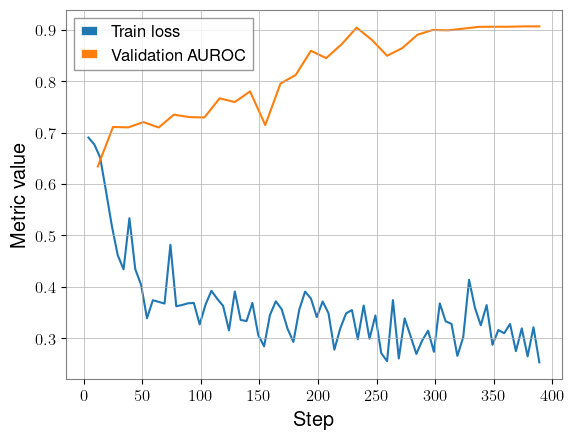

In [34]:
plt.plot(train_steps, train_loss, label="Train loss")
plt.plot(valid_steps, valid_loss, label="Validation AUROC")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Metric value")
plt.show()

As we'd hope, the training loss decreases and the validation AUROC approaches 1.